In [15]:
import re
import ast

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
def evaluate_data(data, prediction_col):
    y = data['Relevance code'].tolist()
    y_predict = data[prediction_col].tolist()
    scores = {
            'Sample size': len(data),
            'accuracy': accuracy_score(y, y_predict),
            'f1': f1_score(y, y_predict, average='binary'),
            'precision_score': precision_score(y, y_predict, zero_division=0, average='binary'),
            'recall_score': recall_score(y, y_predict, zero_division=0, average='binary')}
    return scores

## Import data

In [3]:
cd ..

/Users/gallaghe/Code/nutrition-labels


In [4]:
ensemble_date = '201118'
ensemble_info = f'data/processed/ensemble/{ensemble_date}_training_information_1models.txt'
ensemble_results_file = f'data/processed/ensemble/{ensemble_date}_all_ensemble_results.csv'
grant_file = 'data/raw/wellcome-grants-awarded-2005-2019.csv'

In [5]:
# Import the models names and training file name
with open(ensemble_info, "r") as f:
    for line in f.readlines():
        if 'Ensemble models' in line:
            models = re.sub('Ensemble models: ', '', line)
            models = ast.literal_eval(models)
models

['count_SVM_201022',
 'bert_SVM_scibert_201022',
 'bert_SVM_bert_201022',
 'tfidf_log_reg_201022']

In [6]:
# Import the ensemble results and which data was used in the test set
ensemble_data = pd.read_csv(ensemble_results_file)

# Import the grant data
grant_data = pd.read_csv(grant_file)
grant_data.drop_duplicates(['Internal ID'], inplace=True)

# Merge test data with grant info
test_results = ensemble_data.loc[ensemble_data['How has this grant been used before?']=='Test data'].reset_index(drop=True)
test_results = pd.merge(
    test_results,
    grant_data,
    how = 'left',
    on = ['Internal ID']
    )

## Evaluate fairness

In [7]:
# Found by manually looking at the list in the test data (so might not be conclusive!)
golden_triangle = [
    'University College London', 'Imperial College London', "King's College London",
    'University of Oxford',
    'University of Cambridge'
    ]

In [8]:
# Golden triangle or not
test_results['Golden triangle university'] = ['Golden triangle' if org in golden_triangle else 'Not golden triangle' for org in test_results['Recipient Org:Name']]

# Greater london, international or not
region_grouped = []
for region in test_results['Region']:
    if region == 'Greater London':
        region_grouped.append('Greater London')
    elif region == 'International':
        region_grouped.append('International')
    else:
        region_grouped.append('UK, not greater London')
test_results['Region grouped'] = region_grouped

In [10]:
prediction_cols = [
    f'Ensemble predictions - {num_models} models' for num_models in range(1, 5)
    ] + [f'{model} predictions' for model in models]

data_types = ['Golden triangle university', 'Region grouped']

In [11]:
fairness_results = []
for prediction_col in prediction_cols:
    for column in data_types:
        result = test_results.groupby(column).apply(lambda x: evaluate_data(x, prediction_col)).to_dict()
        for column_type, type_results in result.items():
            column_results = {
                'Prediction column': prediction_col,
                'Data type': column,
                'Type': column_type
            }
            for metric, value in type_results.items():
                column_results[metric] = value
            fairness_results.append(column_results)

fairness_results_df = pd.DataFrame(fairness_results)
fairness_results_df.to_csv(f'data/processed/fairness_results_{ensemble_date}.csv')
fairness_results_df.head(5)

,Prediction column,Data type,Type,Sample size,accuracy,f1,precision_score,recall_score
0,Ensemble predictions - 1 models,Golden triangle university,Golden triangle,41,0.829268,0.837209,0.750000,0.947368
1,Ensemble predictions - 1 models,Golden triangle university,Not golden triangle,66,0.848485,0.871795,0.809524,0.944444
2,Ensemble predictions - 1 models,Region grouped,Greater London,30,0.866667,0.882353,0.789474,1.000000
3,Ensemble predictions - 1 models,Region grouped,International,10,0.800000,0.750000,0.600000,1.000000
4,Ensemble predictions - 1 models,Region grouped,"UK, not greater London",67,0.835821,0.860759,0.809524,0.918919


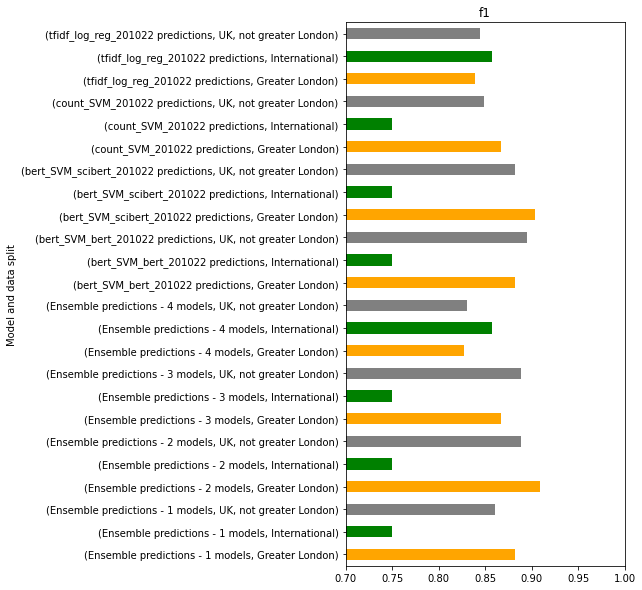

In [49]:
region = fairness_results_df.loc[fairness_results_df['Data type']=='Region grouped']
region.groupby(['Prediction column', 'Type'])['f1'].sum().plot.barh(
    color=['orange', 'green', 'grey'], xlabel='Model and data split', title = 'f1',
    xlim = (0.7,1), figsize=(5,10)
);

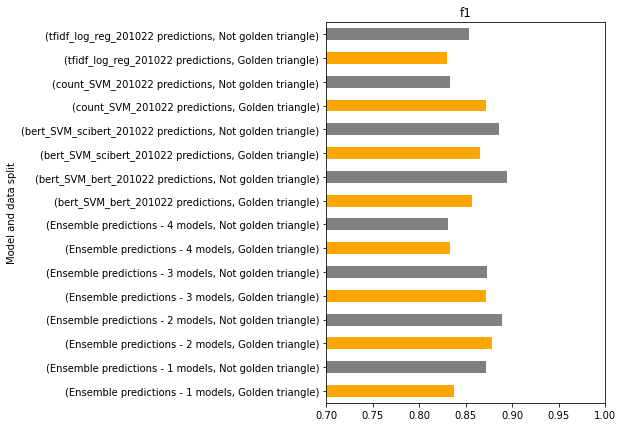

In [52]:
goldtri = fairness_results_df.loc[fairness_results_df['Data type']=='Golden triangle university']
goldtri.groupby(['Prediction column', 'Type'])['f1'].sum().plot.barh(
    color=['orange', 'grey'], xlabel='Model and data split', title = 'f1',
    xlim = (0.7,1), figsize=(5,7)
);

### The range of results for each data type and prediction column

In [53]:
ranges_grouped = fairness_results_df.groupby(
    ['Prediction column', 'Data type']
)[['f1', 'precision_score', 'recall_score']].apply(lambda x: x.max()-x.min())
ranges_grouped

f1  \
Prediction column                   Data type                              
Ensemble predictions - 1 models     Golden triangle university  0.034586   
                                    Region grouped              0.132353   
Ensemble predictions - 2 models     Golden triangle university  0.010840   
                                    Region grouped              0.159091   
Ensemble predictions - 3 models     Golden triangle university  0.001445   
                                    Region grouped              0.138889   
Ensemble predictions - 4 models     Golden triangle university  0.002564   
                                    Region grouped              0.029557   
bert_SVM_bert_201022 predictions    Golden triangle university  0.037594   
                                    Region grouped              0.144737   
bert_SVM_scibert_201022 predictions Golden triangle university  0.020849   
                                    Region grouped              0.153226   
count_SVM_201022 predictions        Golden triangle university  0.038462   
                                    Region grouped              0.116667   
tfidf_log_reg_201022 predictions    Golden triangle university  0.023673   
                                    Region grouped              0.018433   

                                                                precision_score  \
Prediction column                   Data type                                     
Ensemble predictions - 1 models     Golden triangle university         0.059524   
                                    Region grouped                     0.209524   
Ensemble predictions - 2 models     Golden triangle university         0.070707   
                                    Region grouped                     0.314286   
Ensemble predictions - 3 models     Golden triangle university         0.035714   
                                    Region grouped                     0.314286   
Ensemble predictions - 4 models     Golden triangle university         0.048682   
                                    Region grouped                     0.214286   
bert_SVM_bert_201022 predictions    Golden triangle university         0.067391   
                                    Region grouped                     0.271795   
bert_SVM_scibert_201022 predictions Golden triangle university         0.022876   
                                    Region grouped                     0.367742   
count_SVM_201022 predictions        Golden triangle university         0.016667   
                                    Region grouped                     0.266667   
tfidf_log_reg_201022 predictions    Golden triangle university         0.133523   
                                    Region grouped                     0.132353   

                                                                recall_score  
Prediction column                   Data type                                 
Ensemble predictions - 1 models     Golden triangle university      0.002924  
                                    Region grouped                  0.081081  
Ensemble predictions - 2 models     Golden triangle university      0.058480  
                                    Region grouped                  0.135135  
Ensemble predictions - 3 models     Golden triangle university      0.033626  
                                    Region grouped                  0.135135  
Ensemble predictions - 4 models     Golden triangle university      0.039474  
                                    Region grouped                  0.270270  
bert_SVM_bert_201022 predictions    Golden triangle university      0.002924  
                                    Region grouped                  0.081081  
bert_SVM_scibert_201022 predictions Golden triangle university      0.019006  
                                    Region grouped                  0.189189  
count_SVM_201022 predictions        Golden triangle university      0.061404  
                     

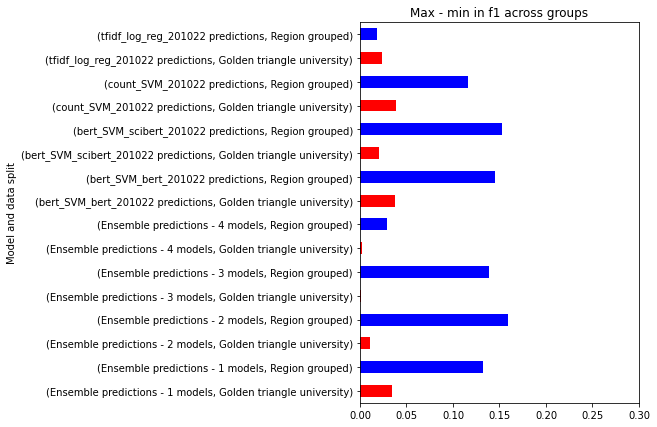

In [74]:
ranges_grouped['f1'].plot.barh(
    color=['red', 'blue'], xlabel='Model and data split', title = 'Max - min in f1 across groups',
    xlim = (0,0.3), figsize=(5,7)
);

### Which models have the lowest mean difference between groups?

In [61]:
top_n = 5

In [62]:
ranges_grouped.groupby('Prediction column').mean().sort_values(by=['f1'],ascending=True).head(top_n)

,f1,precision_score,recall_score
Prediction column,,,
Ensemble predictions - 4 models,0.016060,0.131484,0.154872
tfidf_log_reg_201022 predictions,0.021053,0.132938,0.139185
Ensemble predictions - 3 models,0.070167,0.175000,0.084380
count_SVM_201022 predictions,0.077564,0.141667,0.111783
Ensemble predictions - 1 models,0.083469,0.134524,0.042003


In [63]:
ranges_grouped.groupby('Prediction column').mean().sort_values(by=['precision_score'],ascending=True).head(top_n)

,f1,precision_score,recall_score
Prediction column,,,
Ensemble predictions - 4 models,0.016060,0.131484,0.154872
tfidf_log_reg_201022 predictions,0.021053,0.132938,0.139185
Ensemble predictions - 1 models,0.083469,0.134524,0.042003
count_SVM_201022 predictions,0.077564,0.141667,0.111783
bert_SVM_bert_201022 predictions,0.091165,0.169593,0.042003


In [64]:
ranges_grouped.groupby('Prediction column').mean().sort_values(by=['recall_score'],ascending=True).head(top_n)

,f1,precision_score,recall_score
Prediction column,,,
Ensemble predictions - 1 models,0.083469,0.134524,0.042003
bert_SVM_bert_201022 predictions,0.091165,0.169593,0.042003
Ensemble predictions - 3 models,0.070167,0.175000,0.084380
Ensemble predictions - 2 models,0.084966,0.192496,0.096807
bert_SVM_scibert_201022 predictions,0.087038,0.195309,0.104098


### The results for all the data to compare against

In [14]:
all_test_results = []
for prediction_col in prediction_cols:
    result = evaluate_data(test_results, prediction_col)
    column_results = {
            'Prediction column': prediction_col,
            'Data type': 'All',
            'Type': column_type
        }
    for metric, value in result.items():
        column_results[metric] = value
    all_test_results.append(column_results)

all_test_results_df = pd.DataFrame(all_test_results)

all_test_results_df

,Prediction column,Data type,Type,Sample size,accuracy,f1,precision_score,recall_score
0,Ensemble predictions - 1 models,All,"UK, not greater London",107,0.841121,0.859504,0.787879,0.945455
1,Ensemble predictions - 2 models,All,"UK, not greater London",107,0.878505,0.884956,0.862069,0.909091
2,Ensemble predictions - 3 models,All,"UK, not greater London",107,0.869159,0.872727,0.872727,0.872727
3,Ensemble predictions - 4 models,All,"UK, not greater London",107,0.841121,0.831683,0.913043,0.763636
4,count_SVM_201022 predictions,All,"UK, not greater London",107,0.841121,0.846847,0.839286,0.854545
5,bert_SVM_scibert_201022 predictions,All,"UK, not greater London",107,0.878505,0.878505,0.903846,0.854545
6,bert_SVM_bert_201022 predictions,All,"UK, not greater London",107,0.869159,0.881356,0.825397,0.945455
7,tfidf_log_reg_201022 predictions,All,"UK, not greater London",107,0.841121,0.844037,0.851852,0.836364
